## Load HIV dataset

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("HIV.csv")
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [3]:
string = df.loc[0,'smiles']
print(df.loc[0,'smiles'])
print(string[3])

CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2
1


In [4]:
df.value_counts("activity")

activity
CI    39684
CM     1039
CA      404
Name: count, dtype: int64

In [5]:
df.value_counts("HIV_active")

HIV_active
0    39684
1     1443
Name: count, dtype: int64

## Sampling 

In [6]:
# Separate the dataframe into three categories
df_CI = df[df['activity'] == 'CI']
df_CM = df[df['activity'] == 'CM']
df_CA = df[df['activity'] == 'CA']

# Sampling from each category
sample_CI = df_CI.sample(n=1000, random_state=42) 
sample_CM = df_CM.sample(n=700, random_state=42)
sample_CA = df_CA.sample(n=300, random_state=42)

# Concatenate the samples back into one DataFrame
sampled_sf = pd.concat([sample_CI, sample_CM, sample_CA])

# If you want to shuffle the combined DataFrame
sampled_sf = sampled_sf.sample(frac=1).reset_index(drop=True)
sampled_sf = sampled_sf.drop(columns=['HIV_active'])

In [7]:
# Define the mapping dictionary
activity_mapping = {'CI': 0, 'CM': 1, 'CA': 2}

# Replace the 'activity' column using the mapping dictionary
sampled_sf['activity'] = sampled_sf['activity'].replace(activity_mapping)
sampled_sf

,smiles,activity
0,COc1ccc(OC)c(C=Cc2ccc3ccccc3n2)c1,0
1,Cc1cc(N=Nc2ccc(-c3ccc(N=Nc4ccc(O)c(C(=O)O)c4)c...,0
2,COc1ccc(C2C(=O)c3ccc(OC)cc3OC2c2ccccc2)cc1,0
3,O=C(NN1C(=O)C(Cl)C1c1ccccc1O)c1ccccc1O,0
4,O=[N+]([O-])c1cc(C(F)(F)F)cc2n[se]nc12,0
...,...,...
1995,COc1ccc(OP2OCC(C)O2)cc1,0
1996,Cc1ccc(C)c(NC(=O)CCC(=NNC(=O)c2c(O)ccc3ccccc23...,1
1997,CCN(CC)CC1CCCCN1CC(=O)N1c2cc(Cl)ccc2NC(=O)CC1C,1
1998,Cc1ccc(-c2nc(C)c(C(=O)Nc3ccc(Cl)cc3)s2)cc1,0


## Transform SMILES into GRAPH representation

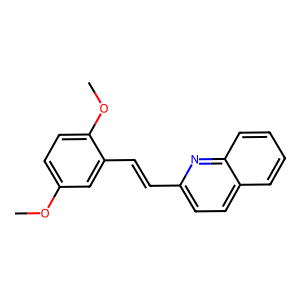

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx

# Visualizing the first molecule's structure as an example
mol = Chem.MolFromSmiles(sampled_sf['smiles'].iloc[0])
Draw.MolToImage(mol)

In [9]:
import torch
from rdkit import Chem
from torch_geometric.data import Data

# Atom and bond preprocessing functions
def atom_features(atom):
    return [
        atom.GetAtomicNum(),             # Atomic number
        atom.GetFormalCharge(),          # Formal charge
        atom.GetDegree(),                # Degree of the atom
        atom.GetHybridization().real,    # Hybridization
        atom.GetIsAromatic(),            # Aromaticity
        atom.GetImplicitValence(),       # Implicit valence
        atom.GetMass(),                  # Atomic mass
    ]

def bond_features(bond):
    bt = bond.GetBondType()
    return [
        bt == Chem.rdchem.BondType.SINGLE,
        bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE,
        bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),  # Conjugation
        bond.IsInRing(),         # Whether the bond is in a ring
    ]

# Conversion from SMILES to graph suitable for GNN
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Create nodes
    node_feats = [atom_features(atom) for atom in mol.GetAtoms()]
    node_feats = torch.tensor(node_feats, dtype=torch.float)
    
    # Create edges
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
        edge_attr += [bond_features(bond), bond_features(bond)]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    return Data(x=node_feats, edge_index=edge_index, edge_attr=edge_attr)

# Apply the function to your dataframe
sampled_sf['graph'] = sampled_sf['smiles'].apply(smiles_to_graph)
print(sampled_sf['graph'].iloc[0].x)
sampled_sf

tensor([[ 6.0000,  0.0000,  1.0000,  4.0000,  0.0000,  3.0000, 12.0110],
        [ 8.0000,  0.0000,  2.0000,  3.0000,  0.0000,  0.0000, 15.9990],
        [ 6.0000,  0.0000,  3.0000,  3.0000,  1.0000,  0.0000, 12.0110],
        [ 6.0000,  0.0000,  2.0000,  3.0000,  1.0000,  1.0000, 12.0110],
        [ 6.0000,  0.0000,  2.0000,  3.0000,  1.0000,  1.0000, 12.0110],
        [ 6.0000,  0.0000,  3.0000,  3.0000,  1.0000,  0.0000, 12.0110],
        [ 8.0000,  0.0000,  2.0000,  3.0000,  0.0000,  0.0000, 15.9990],
        [ 6.0000,  0.0000,  1.0000,  4.0000,  0.0000,  3.0000, 12.0110],
        [ 6.0000,  0.0000,  3.0000,  3.0000,  1.0000,  0.0000, 12.0110],
        [ 6.0000,  0.0000,  2.0000,  3.0000,  0.0000,  1.0000, 12.0110],
        [ 6.0000,  0.0000,  2.0000,  3.0000,  0.0000,  1.0000, 12.0110],
        [ 6.0000,  0.0000,  3.0000,  3.0000,  1.0000,  0.0000, 12.0110],
        [ 6.0000,  0.0000,  2.0000,  3.0000,  1.0000,  1.0000, 12.0110],
        [ 6.0000,  0.0000,  2.0000,  3.0000,  1.000

,smiles,activity,graph
0,COc1ccc(OC)c(C=Cc2ccc3ccccc3n2)c1,0,"[(x, [tensor([ 6.0000, 0.0000, 1.0000, 4.00..."
1,Cc1cc(N=Nc2ccc(-c3ccc(N=Nc4ccc(O)c(C(=O)O)c4)c...,0,"[(x, [tensor([ 6.0000, 0.0000, 1.0000, 4.00..."
2,COc1ccc(C2C(=O)c3ccc(OC)cc3OC2c2ccccc2)cc1,0,"[(x, [tensor([ 6.0000, 0.0000, 1.0000, 4.00..."
3,O=C(NN1C(=O)C(Cl)C1c1ccccc1O)c1ccccc1O,0,"[(x, [tensor([ 8.0000, 0.0000, 1.0000, 3.00..."
4,O=[N+]([O-])c1cc(C(F)(F)F)cc2n[se]nc12,0,"[(x, [tensor([ 8.0000, 0.0000, 1.0000, 3.00..."
...,...,...,...
1995,COc1ccc(OP2OCC(C)O2)cc1,0,"[(x, [tensor([ 6.0000, 0.0000, 1.0000, 4.00..."
1996,Cc1ccc(C)c(NC(=O)CCC(=NNC(=O)c2c(O)ccc3ccccc23...,1,"[(x, [tensor([ 6.0000, 0.0000, 1.0000, 4.00..."
1997,CCN(CC)CC1CCCCN1CC(=O)N1c2cc(Cl)ccc2NC(=O)CC1C,1,"[(x, [tensor([ 6.0000, 0.0000, 1.0000, 4.00..."
1998,Cc1ccc(-c2nc(C)c(C(=O)Nc3ccc(Cl)cc3)s2)cc1,0,"[(x, [tensor([ 6.0000, 0.0000, 1.0000, 4.00..."


## GNN

In [10]:
for i, data in enumerate(sampled_sf['graph']):
    data.y = torch.tensor([sampled_sf['activity'][i]], dtype=torch.long)
print(sampled_sf['graph'][0])

Data(x=[22, 7], edge_index=[2, 48], edge_attr=[48, 6], y=[1])


In [13]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader 

sampled_sf = sampled_sf.reset_index(drop=True)
# Split data into training and testing sets
train_dataset, val_dataset = train_test_split(sampled_sf['graph'].tolist(), test_size=0.2, random_state=42)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [12]:
import torch.optim as optim
from tqdm import tqdm
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.utils import scatter
from torch_geometric.loader import DataLoader as GraphDataLoader

class Layer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = Sequential(
            Linear(in_dim, out_dim),
            ReLU()
        )
    
    def forward(self, x):
        return self.layers(x)

class MessagePassingLayer(nn.Module):
    def __init__(self, node_hidden_dim, edge_hidden_dim):
        super().__init__()
        self.edge_net = Layer(2 * node_hidden_dim + edge_hidden_dim, edge_hidden_dim)
        self.node_net = Layer(node_hidden_dim + edge_hidden_dim, node_hidden_dim)
    
    def forward(self, node_features, edge_features, edge_index):
        src, dest = edge_index[0], edge_index[1]
        edge_features_combined = torch.cat([
            node_features[src],
            node_features[dest],
            edge_features
        ], dim=1)
        updated_edge_features = self.edge_net(edge_features_combined)
        aggr_edge_features = scatter(updated_edge_features, src, dim_size=node_features.size(0))
        node_features_combined = torch.cat([node_features, aggr_edge_features], dim=1)
        updated_node_features = self.node_net(node_features_combined)
        return updated_node_features, updated_edge_features

class GraphNet(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim, num_classes):
        super().__init__()
        self.node_embed = Layer(node_input_dim, node_hidden_dim)
        self.edge_embed = Layer(edge_input_dim, edge_hidden_dim)
        self.message_passing = MessagePassingLayer(node_hidden_dim, edge_hidden_dim)
        self.readout = Linear(node_hidden_dim, num_classes)
    
    def forward(self, data):
        node_hidden = self.node_embed(data.x)
        edge_hidden = self.edge_embed(data.edge_attr)
        node_hidden, edge_hidden = self.message_passing(node_hidden, edge_hidden, data.edge_index)
        graph_embeddings = scatter(node_hidden, data.batch, dim=0)
        out = self.readout(graph_embeddings)
        return out

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

class GNNTrainer:
    def __init__(self, model, batch_size=32, learning_rate=1e-3, epoch=50, l2=1e-5):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        
    def train(self, train_loader, draw_curve=True):  
        self.model.train()
        loss_func = nn.CrossEntropyLoss()
        batch_loss_list = []
        for i in range(self.epoch):
            print(f"Epoch: {i}")
            for batch_data in tqdm(train_loader, leave=False):
                self.optimizer.zero_grad()
                batch_pred = self.model(batch_data)  # Assume model handles the batch_data correctly
                batch_loss = loss_func(batch_pred, batch_data.y)
                batch_loss.backward()
                self.optimizer.step()

                batch_loss_list.append(batch_loss.item())
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(np.arange(len(batch_loss_list)), batch_loss_list)
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
            plt.show()
        
        return batch_loss_list
    
    def evaluate(self, val_loader, draw_curve=True):
        self.model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch_data in tqdm(val_loader, leave=False):
                batch_pred = self.model(batch_data)
                y_pred.extend(batch_pred.argmax(dim=1).cpu().numpy())
                y_true.extend(batch_data.y.cpu().numpy())
        
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        accuracy = np.mean(y_true == y_pred)
        
        if draw_curve:
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title("Confusion Matrix")
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            
        return accuracy

In [14]:
num_classes = 3  # 'CI', 'CM', 'CA'
node_input_dim = sampled_sf['graph'][0].x.shape[1] 
edge_input_dim = sampled_sf['graph'][0].edge_attr.shape[1]  
node_hidden_dim = 64
edge_hidden_dim = 64
model = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim, num_classes)

GraphNet - Number of parameters: 21763
Epoch: 0


Epoch: 1


Epoch: 2


Epoch: 3


Epoch: 4


Epoch: 5


Epoch: 6


Epoch: 7


Epoch: 8


Epoch: 9


Epoch: 10


Epoch: 11


Epoch: 12


Epoch: 13


Epoch: 14


Epoch: 15


Epoch: 16


Epoch: 17


Epoch: 18


Epoch: 19


Epoch: 20


Epoch: 21


Epoch: 22


Epoch: 23


Epoch: 24


Epoch: 25


Epoch: 26


Epoch: 27


Epoch: 28


Epoch: 29


Epoch: 30


Epoch: 31


Epoch: 32


Epoch: 33


Epoch: 34


Epoch: 35


Epoch: 36


Epoch: 37


Epoch: 38


Epoch: 39


Epoch: 40


Epoch: 41


Epoch: 42


Epoch: 43


Epoch: 44


Epoch: 45


Epoch: 46


Epoch: 47


Epoch: 48


Epoch: 49


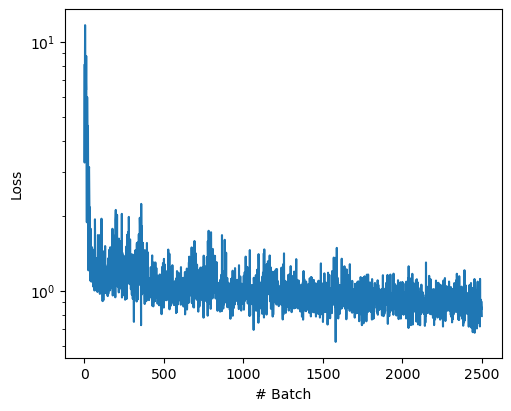

[8.05967903137207,
 3.273944616317749,
 5.08729362487793,
 7.996676445007324,
 11.671562194824219,
 8.35889720916748,
 4.674300670623779,
 3.6381733417510986,
 7.123345375061035,
 7.248134136199951,
 6.41267204284668,
 8.77109146118164,
 5.569512844085693,
 4.412312030792236,
 2.1233866214752197,
 1.8834784030914307,
 4.294487476348877,
 5.991480827331543,
 4.72153377532959,
 2.7404091358184814,
 2.287888765335083,
 2.7211148738861084,
 4.596879005432129,
 2.849921226501465,
 2.132659673690796,
 1.207118272781372,
 2.254261016845703,
 2.7763161659240723,
 3.0554049015045166,
 3.139784097671509,
 2.6063051223754883,
 2.20333194732666,
 1.3146781921386719,
 2.1669702529907227,
 1.7869490385055542,
 1.6583291292190552,
 1.098384976387024,
 1.27023184299469,
 1.4553078413009644,
 1.7744389772415161,
 1.315610408782959,
 1.1625661849975586,
 1.452470302581787,
 1.0874634981155396,
 1.153174638748169,
 1.385875940322876,
 1.4963107109069824,
 1.3486303091049194,
 1.486943244934082,
 1.130601

In [15]:
trainer = GNNTrainer(model)
trainer.train(train_loader)

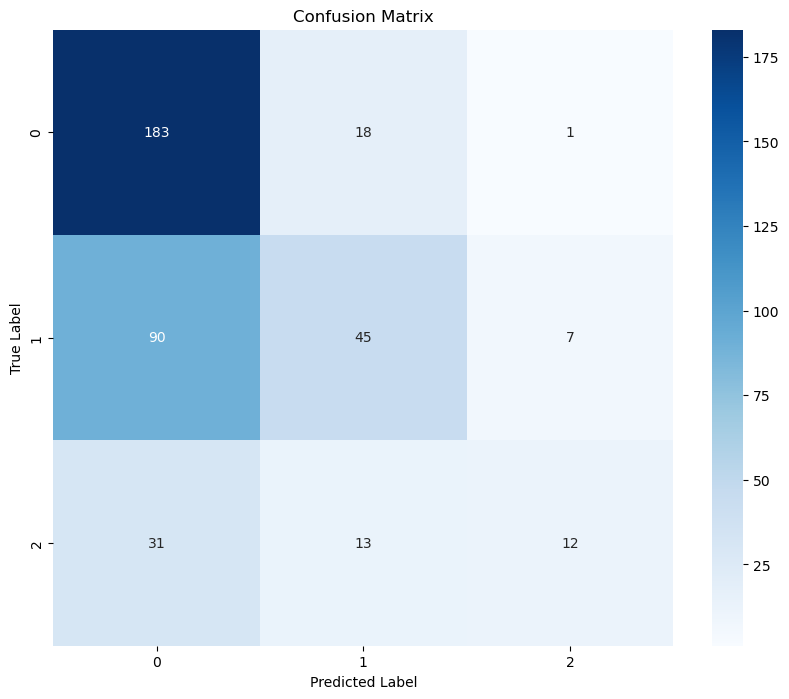

0.6

In [16]:
# evaulate
trainer.evaluate(val_loader)